# 42028 Face Mask Detection
trained with MobileNet

## Step 1 - Import the necessary modules

In this step, modules to be used are imported and google drive is also mounted

In [ ]:
import os
import tensorflow as tf
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop,Adam
from PIL import ImageFile,Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


## Step 2 - Load the dataset to be trained

In this step, 50,000 training images and 8360 images were passed into image geneartors


In [ ]:
filepath ='/content/gdrive/MyDrive/facemask/train/maskmouth'
count = 0
for file in os.listdir(filepath):
  count+=1
print(count)



15222


In [ ]:
train_dir ="/content/gdrive/MyDrive/facemask/train"
validate_dir = '/content/gdrive/MyDrive/facemask/test'
train_datagen = ImageDataGenerator(
      brightness_range=[0.2, 1.6],
      rotation_range=0, 
      width_shift_range=0.1,
      height_shift_range=0.1, 
      shear_range=0.2, 
      zoom_range=0.2,
      horizontal_flip=True, 
      fill_mode="nearest",
      rescale=1./255,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300,300),
        batch_size=20,
        class_mode='categorical')

Found 50000 images belonging to 4 classes.


Labels for 4 classes present in the training dataset

In [ ]:
labelmap = (train_generator.class_indices)
print(labelmap)

{'maskchin': 0, 'maskmouth': 1, 'maskoff': 2, 'maskon': 3}


In [ ]:
validation_generator = test_datagen.flow_from_directory(
        validate_dir,
        target_size=(300,300),
        batch_size=20,
        class_mode='categorical')

Found 8360 images belonging to 4 classes.


Labels for 4 classes present in the validation dataset

In [ ]:
labelmap = (validation_generator.class_indices)
print(labelmap)

{'maskchin': 0, 'maskmouth': 1, 'maskoff': 2, 'maskon': 3}


## Step 3 - Load the Model to be trained

In [ ]:
from tensorflow.keras.applications import MobileNet
convbase = MobileNet(weights=None,include_top=False,input_shape=(300,300,3))
convbase.summary()

Model: "mobilenet_1.00_300"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 150, 150, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 150, 150, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 150, 150, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 150, 150, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 150, 150, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 150, 150, 32

Add the necessary full connected layer.

In [ ]:
model = tf.keras.models.Sequential()
model.add(convbase)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_300 (Function (None, 9, 9, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 3,492,292
Trainable params: 3,470,404
Non-trainable params: 21,888
_________________________________________________________________


Compile the model

In [ ]:
model.compile(optimizer=Adam(lr=0.000125),
              loss='categorical_crossentropy',
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Declare checkpoint filepath to save the model

In [ ]:
filepath='/content/gdrive/MyDrive/facemask/augmentation/weights.{epoch:02d}-{val_loss:.2f}.hdf5'

checkpoint = checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

## Step 4 - Train the Model

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=2500,  # 680 images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      validation_steps= 418,  # 340 images = batch_size * steps
      callbacks = [checkpoint],
      verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
2500/2500 - 17151s - loss: 0.2574 - acc: 0.8988 - val_loss: 0.1884 - val_acc: 0.9396
Epoch 2/30
2500/2500 - 1223s - loss: 0.0650 - acc: 0.9796 - val_loss: 0.0388 - val_acc: 0.9866
Epoch 3/30
2500/2500 - 1210s - loss: 0.0415 - acc: 0.9877 - val_loss: 0.0195 - val_acc: 0.9940
Epoch 4/30
2500/2500 - 1233s - loss: 0.0288 - acc: 0.9916 - val_loss: 0.0628 - val_acc: 0.9816
Epoch 5/30
2500/2500 - 1238s - loss: 0.0227 - acc: 0.9934 - val_loss: 0.0072 - val_acc: 0.9981
Epoch 6/30
2500/2500 - 1205s - loss: 0.0174 - acc: 0.9949 - val_loss: 0.0101 - val_acc: 0.9977
Epoch 7/30
2500/2500 - 1202s - loss: 0.0167 - acc: 0.9952 - val_loss: 0.0080 - val_acc: 0.9977
Epoch 8/30
2500/2500 - 1212s - loss: 0.0128 - acc: 0.9964 - val_loss: 0.0173 - val_acc: 0.9953
Epoch 9/30
2500/2500 - 1201s - loss: 0.0102 - acc: 0.9969 - val_loss: 0.0046 - val_acc: 0.9986
Epoch 10/30
2500/2500 - 1205s - loss: 0.0099 - acc: 0.9972 - val_loss: 0.0054 - val_acc: 0.9984
Epoch 11/30
2500/2500 - 1243s - loss: 0.0097 - a

Trained Model Evaluation

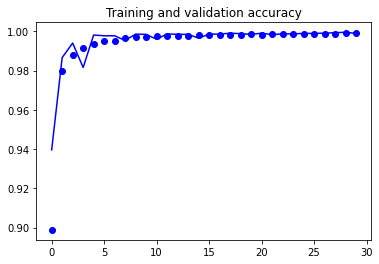

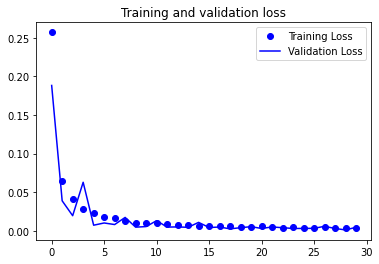

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Optional Step - Convert the traind model into tensorflow


In [ ]:
import tensorflow as tf
model2 = tf.keras.models.load_model('/content/gdrive/MyDrive/facemask/model11.hdf5')
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflmodel = converter.convert()
file = open( 'yourmodel.tflite' , 'wb' ) 
file.write( tflmodel )

INFO:tensorflow:Assets written to: /tmp/tmpuhuwxgtn/assets


INFO:tensorflow:Assets written to: /tmp/tmpuhuwxgtn/assets


13859956

In [ ]:
model2 = tf.keras.models.load_model('/content/gdrive/MyDrive/facemask/model11.hdf5')

In [ ]:
model2.save('/content/gdrive/MyDrive/facemask/model.h5')

## Step 5 - Test the Model

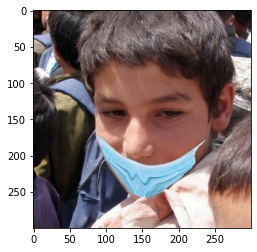

[[1.5567050e-08 1.0000000e+00 9.8867066e-15 6.7306436e-09]]
Mask Mouth


In [ ]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing import image
# from keras.applications import preprocess_input, decode_predictions
from keras.applications.mobilenet import preprocess_input, decode_predictions
# Load the ResNet50 model with pretrained weights
model2 = tf.keras.models.load_model('/content/gdrive/MyDrive/facemask/augmentation/weights.30-0.00.hdf5')
img_path = '/content/gdrive/MyDrive/facemask/testimages/maskmouth_3.jpg'
# img = image.load_img(img_path, target_size=(300, 300))

########
img = cv2.imread(img_path)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(gray_image)
plt.show()
########

x = image.img_to_array(gray_image)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
# print(x.shape)
# print(gray_image.shape)
# plt.imshow(x)
# plt.show()
# features = model.predict(x)
preds = model2.predict(x)
prediction = np.argmax(preds)
print(preds)
if prediction == 0:
  print("Mask Chin")
elif prediction == 1:
  print("Mask Mouth")
elif prediction == 2:
  print("Mask OFF")
else:
  print("Mask On")

# print('Predicted:',decode_predictions(preds, top=3)[0])